# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits import mplot3d
from scipy.integrate import cumtrapz
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import os
import pickle
from pyfuncs import *

import time as st

startdir = '/Users/leo/Desktop/ResearchPhD/PitchControl/analysis/'
%qtconsole

# Read in selected data, combine into one large dataframe

In [2]:
runDates = ['20210803_1','20210816','20210817_1','20210818_1']

# Load dataframes
os.chdir(os.path.join(startdir,'preprocessedCache'))
for i,d in enumerate(runDates):
    dtemp = pd.read_hdf(d+'.h5')
    dtemp['date'] =  d
    if i==0:
        df = dtemp
    else:
        df = df.append(dtemp)
# Load other relevant variables
file = open(os.path.join(startdir, 'preprocessedCache', 'vars')+'.pkl', 'rb')
translations, runDates = pickle.load(file)
file.close()
# Important information that's quick to hard-code in
channelsEMG = ['LDVM', 'LDLM', 'RDLM', 'RDVM']
channelsFT = ['fx', 'fy', 'fz', 'mx', 'my', 'mz']
fsamp = 10000


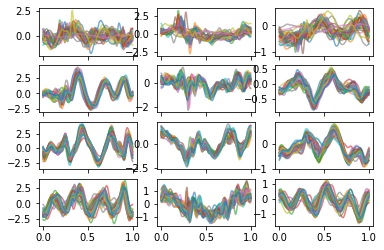

In [8]:
# Quick test plot
fig, ax = plt.subplots(len(runDates), 3, sharex=True)
for i,d in enumerate(runDates):
    dt = df.loc[df.date==d].copy()
    dt = dt.loc[dt.pulse==dt.pulse.iloc[0]]
    for j,m in enumerate(channelsFT[3:]):
        for jj in np.unique(dt['wb']):
            ax[i,j].plot(dt.loc[dt['wb']==jj, 'phase'], dt.loc[dt['wb']==jj, m], alpha=0.6)

# Torques in quiescent moth trials used to make COM translations
Works as a check to indicate that COM has been found: All torques plotted should be minimized to center around 0

[array([11.34315774, -1.99116011, 55.0768696 ]),
 array([ 4.90710636, -8.55999895, 57.73359689]),
 array([ 8.18208076, -1.39892207, 55.71024836]),
 array([12.81044166, -2.61514537, 53.96501382])]

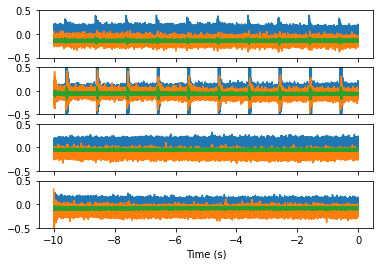

In [11]:
readFrom = 'dropbox'
fig, ax = plt.subplots(len(runDates), 1, sharex=True, sharey=True)
for ii,date in enumerate(runDates):
        # Read empty FT for bias
        biasmat, _, fsamp = readRaw(date, 'empty', doFT=True, readFrom=readFrom)
        bias = biasmat.mean(axis=0)[1:-1]
        # Use quiescent moth from stim characterization to find translation to COM
        charTrials = whichTrials(date, purpose='char', readFrom=readFrom)
        M, _, _ = readRaw(date, str(charTrials[0]).zfill(3), doFT=True, readFrom=readFrom)
        mat = M.mean(axis=0)[1:-1]
        # Apply calibration matrix and bias, get mean forces and torques for quiescent moth
        meanFT = transformFTdata((mat-bias).transpose(), M_trans=np.identity(6))
        lx,ly,lz = translations[runDates.index(date)].x
        lz = lz+20
        M_trans = np.array([
                [1,0,0,0,0,0],
                [0,1,0,0,0,0],
                [0,0,1,0,0,0],
                [0, lz, -ly, 1, 0, 0],
                [-lz, 0, lx, 0, 1, 0],
                [ly, -lx, 0, 0, 0, 1]
                ])
        new = transformFTdata((M[:,1:7]-bias).transpose(), M_trans=M_trans)
        for i in range(3):
                ax[ii].plot(M[:,0], new[:,3+i])
ax[len(runDates)-1].set_xlabel('Time (s)')
ax[0].set_ylim((-0.5,0.5))
[translations[i].x for i in range(len(runDates))]

# Look for ways to split by upstroke and downstroke

Why not split upstroke and downstroke (or, at least, split the wingstroke into halves) by taking the other points where the hilbert transform angle flips across zero?

# Estimating "actual pitch" from pitch torque

I am slightly suspicious of this, partially because I don't trust that we've actually transformed FT matrix to be at the real COM, especially going from individual to individual. How much would that throw off this analysis? Do we have stronger ways to verify?

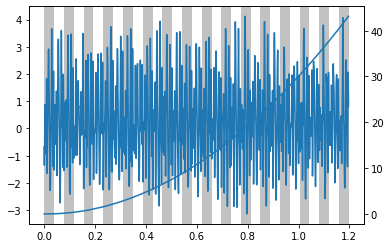

In [3]:
dt = df.loc[(df.date=='20210817_1') & (df.pulse==1),].copy()
dt.Time -= dt.Time.iloc[0]

fsamp = 10000
Iyy = 266.7/1000/(1000**2) # gmm^2 to kg m^2

plt.figure()
time = dt.Time.to_numpy()
mx = dt.mx
theta = cumtrapz(cumtrapz(mx/1000**2/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
plt.plot(time, dt.mx)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time[1:-1], theta)

# Phase-aligned vs. spike-aligned torque waveforms

Similar to Simon's 2015 PLS paper; compare waveform alignment when aligned by wingbeat phase (zero crossing of hilbert transform) vs when aligned by first spike timing of a given muscle

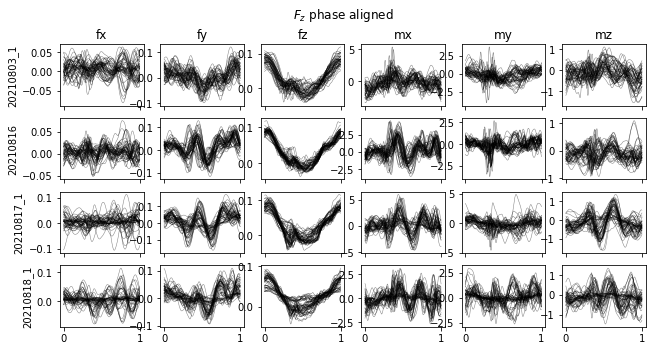

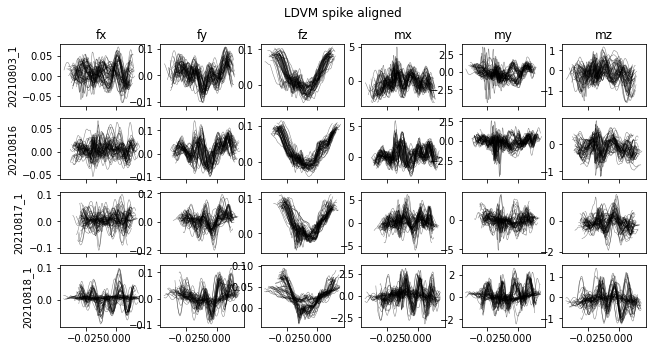

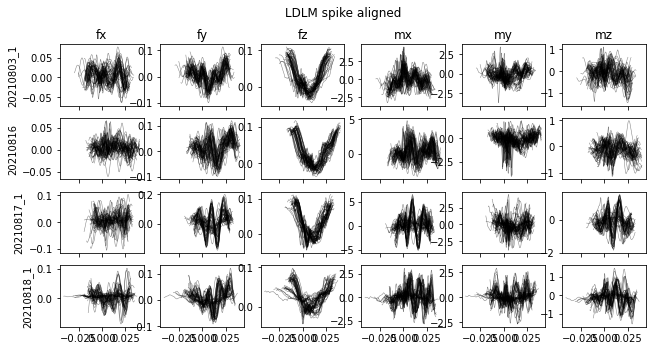

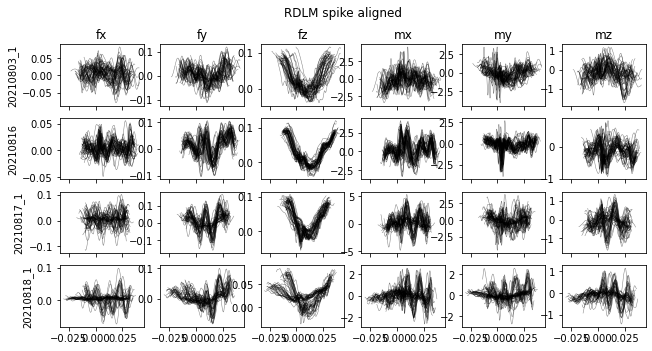

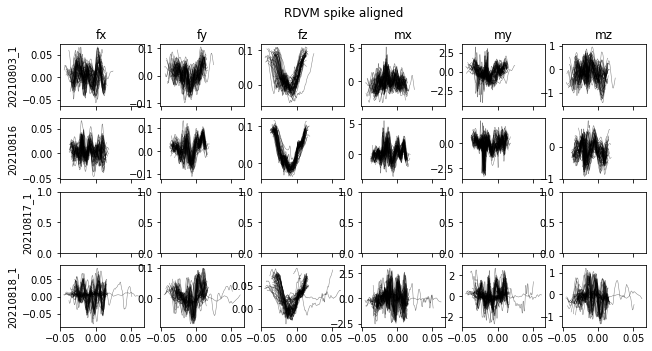

In [10]:
nwb = 50 # How many wingbeats to sample

#--- Fz phase aligned
fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=(10.5,5.2), sharex=True)
for i,d in enumerate(runDates):
    # grab this date
    dt = df.loc[(df.date==d) & (df.wb<-1),].copy()
    # Index the groups, select random subset
    g = dt.groupby(['pulse','wb'])
    a = np.arange(g.ngroups)
    np.random.shuffle(a)
    dt = dt[g.ngroup().isin(a[:nwb])]
    # Loop over randomly chosen groups and plotting variables, and plot
    for name, group in dt.groupby(['pulse','wb']):
        for j,m in enumerate(channelsFT):
            ax[i,j].plot(group.phase, group[m],
                         lw=0.5, alpha=0.5, color='black')
fig.suptitle(r'$F_z$ phase aligned')
for i,m in enumerate(channelsFT):
    ax[0,i].set_title(m)
for i,d in enumerate(runDates):
    ax[i,0].set_ylabel(d)

#--- First spike aligned
for alignMuscle in channelsEMG:
    fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=(10.5,5.2), sharex=True)
    for i,d in enumerate(runDates):
        # Grab data
        dt = df.loc[(df.date==d) & (df.wb<-1) & (~np.isnan(df[alignMuscle+'_fs']))].copy()
        # Continue only if aligning muscle had data 
        if len(dt)!=0:
            # Index the groups, select random subset
            g = dt.groupby(['pulse','wb'])
            a = np.arange(g.ngroups)
            np.random.shuffle(a)
            dt = dt[g.ngroup().isin(a[:nwb])]
            # Loop over randomly chosen groups and plotting variables, and plot
            for name, group in dt.groupby(['pulse','wb']):
                for j,m in enumerate(channelsFT):
                    ax[i,j].plot(group.Time-group.Time.iloc[int(group[alignMuscle+'_fs'].iloc[0])],
                                group[m],
                                lw=0.5, alpha=0.5, color='black')
    fig.suptitle(alignMuscle+' spike aligned')
    for i,m in enumerate(channelsFT):
        ax[0,i].set_title(m)
    for i,d in enumerate(runDates):
        ax[i,0].set_ylabel(d)


# Top-down contour plots of torque traces separated by some variable
General method for taking a start point (spike triggered, stim triggered, wingbeat, etc), a separating variable (like mean torque, or induced spike time difference), and plotting torque traces over time in 3D represenation

***TODO***: 
- Make sure this is actually the right data: Recreate the stimphase vs. spikephase plot to verify. 
- Try other alignment methods, aligning off of arbitrary different variables

4.025790858999244
1.5371200049994513
2.3008022900012293
2.228355081999325


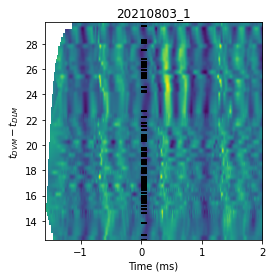

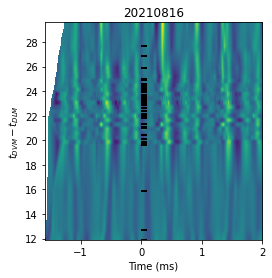

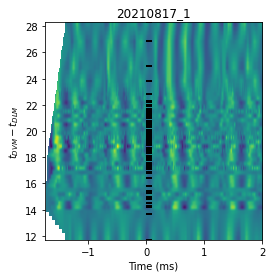

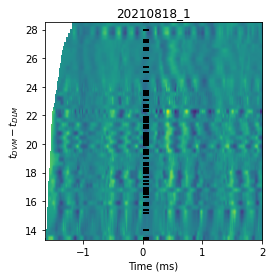

In [141]:
usewb = (-2, 2) # ignore all wingbeat except in this range
usewindow = (-50, 150) # ms, window to actually observe around zero'd time
ngridx, ngridy = 500, 50
# Loop over dates
for d in runDates:
    # Figure setup
    fig = plt.figure()
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
    dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
    dt.loc[(dt['tdl']<0) | (dt['tdr']<0), ['tdl','tdr']] = np.nan
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    mat = np.zeros((3,ngroup*groupsize))
    i = 0
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        
        glen = len(g.Time)
        # mat[0,i:i+glen] = g.Time*1000 # X
        mat[0,i:i+glen] = g.phase+g.wb # X 
        mat[1,i:i+glen] = thiscol # Y
        mat[2,i:i+glen] = g.mx # Z
        i += glen
    # Trim excess length, nan points
    excess = np.argmin(np.flip(mat[0,:]==0))
    mat = mat[:,0:-excess]
    mat = mat[:, ~np.isnan(mat).any(axis=0)]
    mat = mat[:, mat[1,:]<30]
    # Make grid to draw image on
    tic = st.perf_counter()
    xmin, xmax = np.min(mat[0,:]), np.max(mat[0,:])
    ymin, ymax = np.min(mat[1,:]), np.max(mat[1,:])
    gridx, gridy = np.mgrid[xmin:xmax:ngridx*1j, ymin:ymax:ngridy*1j]
    gridz = griddata(mat[0:2,:].T, mat[2,:], (gridx,gridy), method='linear')
    print(st.perf_counter()-tic)
    # Plot!
    plt.imshow(gridz.T, extent=[xmin, xmax, ymin, ymax], origin='lower', aspect=(xmax-xmin)/(ymax-ymin))
    # plt.hlines(mat[1,:], xmin=0, xmax=2, color='k', lw=0.1)
    plt.hlines(mat[1,:], xmin=0, xmax=0.1, color='k', lw=0.1)
    # Labels
    plt.title(d)
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$t_{DVM}-t_{DLM}$')


The problem? So far nothing really stands out. No consistent trends, at least aligned along the axis of DVM-DLM timing differences, induced or otherwise. Might rewrite to take a summary statistic in each location (like a mean) but unlikely to show much more

Levels of sophistication needed. Spike-triggered, time-domain might be fine when separated into deciles of wingbeat frequency

Creation of phase column based on spike times? 0-1 from first spike to first spike?

TODO: Change above figure to not interpolate, instead plot raw traces top-down with color tied to z height

# Recreate waveforms sorted by $\Delta t$ decile plot

Text(0.5, 1.0, '$\\Delta (t_{DVM}-t_{DLM})$')

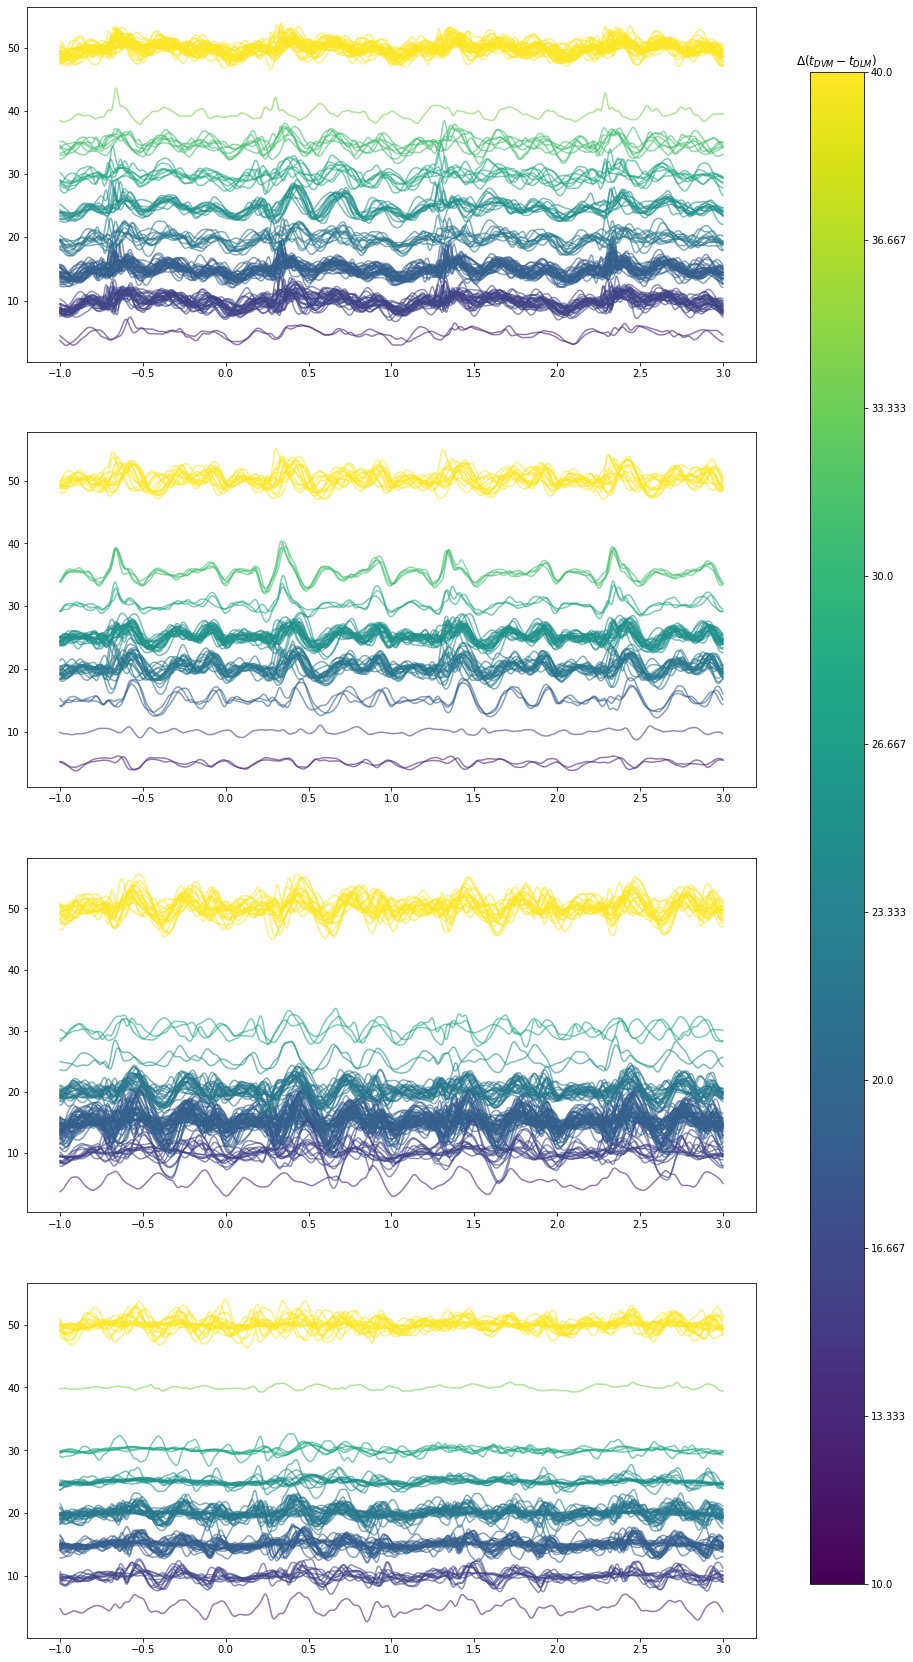

In [173]:
usewb = (-1, 3) # ignore all wingbeat except in this range
nbin = 10
# bins = np.linspace(-3, 16, nbin)
bins = np.linspace(10, 40, nbin)

fig, ax = plt.subplots(len(runDates), 1, figsize=(15,30))
viridis = cmx.get_cmap('viridis')

# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
    dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
    dt.loc[(dt['tdl']<0) | (dt['tdr']<0), ['tdl','tdr']] = np.nan
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    vals = []
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        vals.append(thiscol)
        thisbin = np.digitize(thiscol, bins)
        ax[di].plot(g.phase+g.wb, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
mincol, maxcol = bins[0], bins[-1]
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(bins-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in bins])
cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# PCA of torque waveforns

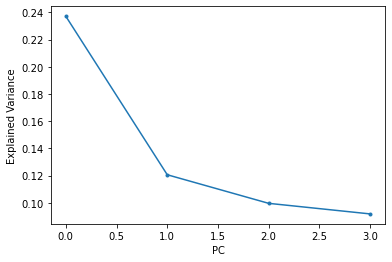

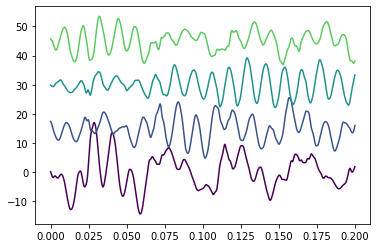

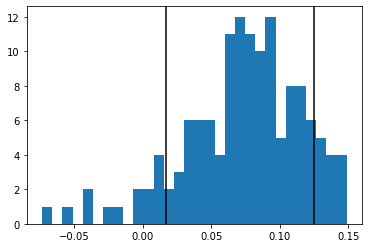

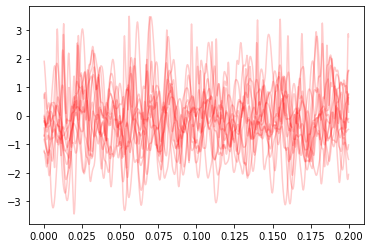

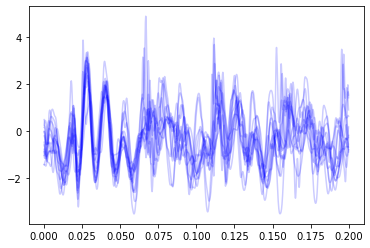

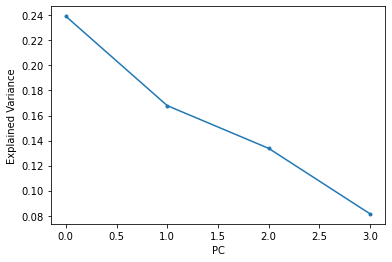

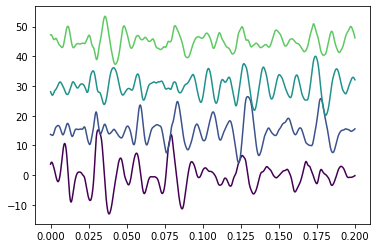

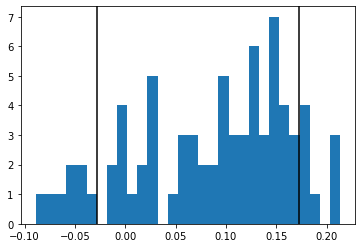

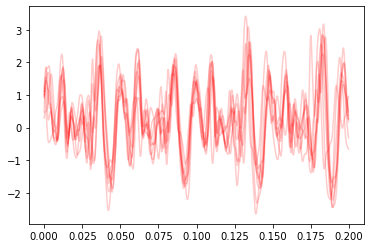

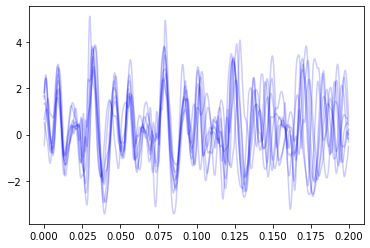

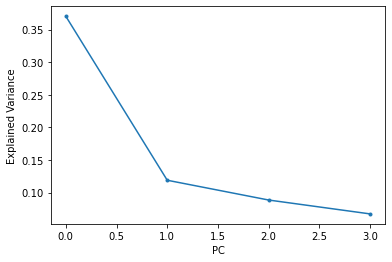

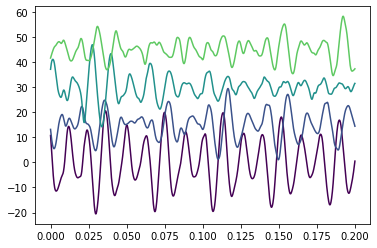

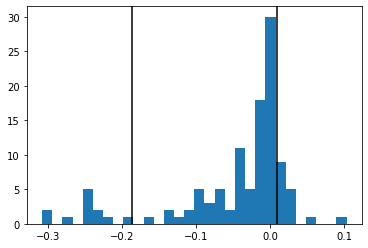

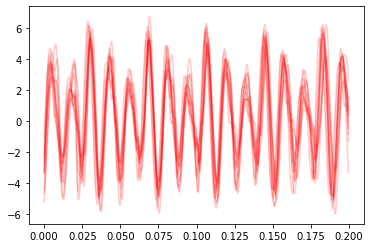

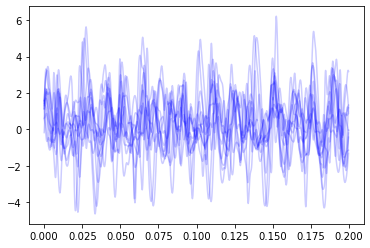

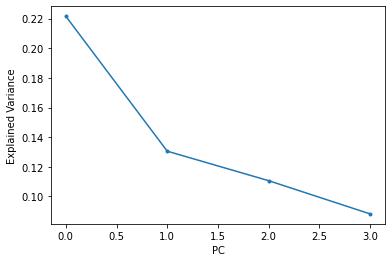

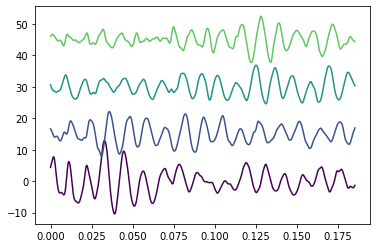

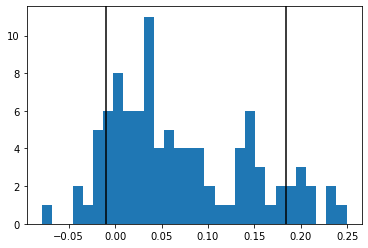

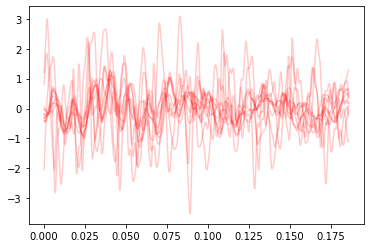

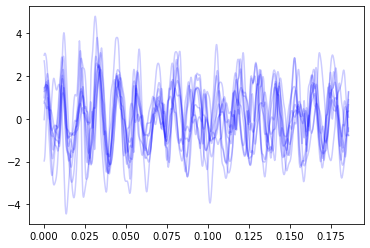

In [169]:
ncomp = 4
usewb = (-2, 6) # ignore all wingbeat except in this range
usewindow = (-100, 200) # ms, window to actually observe around zero'd time
viridis = cmx.get_cmap('viridis')

# Loop over dates
for d in runDates:
    # d = '20210818_1'
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
    dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
    dt.loc[(dt['tdl']<0) | (dt['tdr']<0), ['tdl','tdr']] = np.nan
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    # Group dataframe, prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    mat = np.full((ngroup,groupsize), np.nan)
    # Loop over each pulse, add to matrix
    for i, (name, g) in enumerate(grouped_df):
        vec = g.loc[g.Time>=0]
        mat[i,0:len(vec)] = vec.mx
    # Create time vector 
    tvec = np.linspace(0, (mat.shape[1]-1)/fsamp, mat.shape[1])
    # Trim nan points (in the future can interpolate nans?)
    tvec = tvec[~np.isnan(mat).any(axis=0)]
    mat = mat[:, ~np.isnan(mat).any(axis=0)]

    # Take PCA
    pca = PCA(n_components=ncomp)
    pc = pca.fit_transform(mat.T)

    # Plot explained variance
    plt.figure()
    plt.plot(pca.explained_variance_ratio_, '.-')
    plt.xlabel('PC')
    plt.ylabel('Explained Variance')
    # Plot main PC's
    plt.figure()
    for i in range(pc.shape[1]):
        plt.plot(tvec, pc[:,i]+i*15, color=viridis(i/pc.shape[1]))
    # Plot distribution of PC1
    # Get deciles
    deciles = np.percentile(pca.components_[0,:], np.arange(0, 100, 10))
    plt.figure()
    plt.hist(pca.components_[0,:], bins=30)
    plt.axvline(x=deciles[1], color='black')
    plt.axvline(x=deciles[-1], color='black')

    # Get which traces are in lower and upper percentile, plot those
    plt.figure()
    for j in np.where(pca.components_[0,:]<=deciles[1])[0]:
        plt.plot(tvec, mat[j,:], color='red', alpha=0.2)
    plt.figure()
    for j in np.where(pca.components_[0,:]>=deciles[-1])[0]:
        plt.plot(tvec, mat[j,:], color='blue', alpha=0.2)


Look at how PC's vary with stimulation spike times

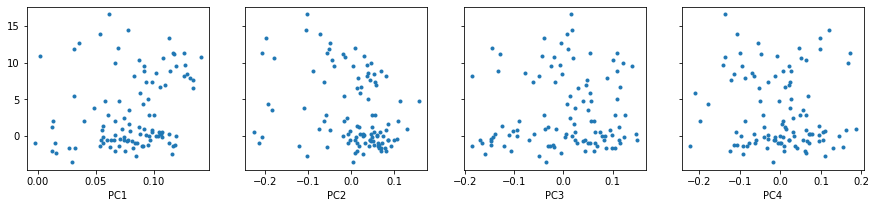

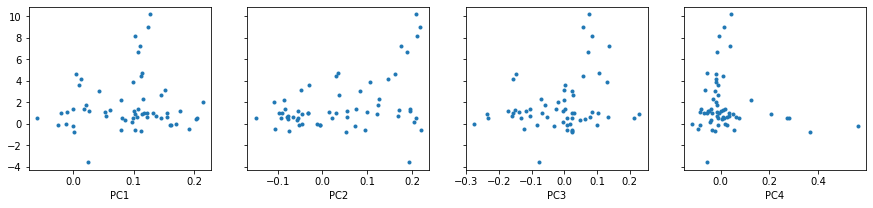

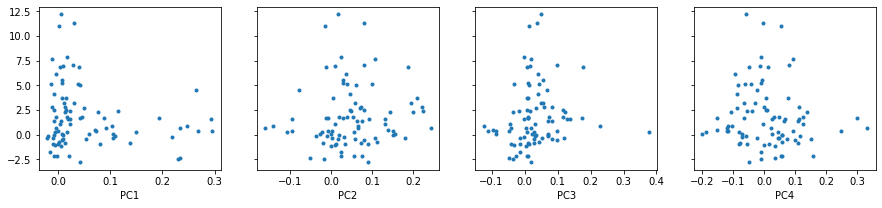

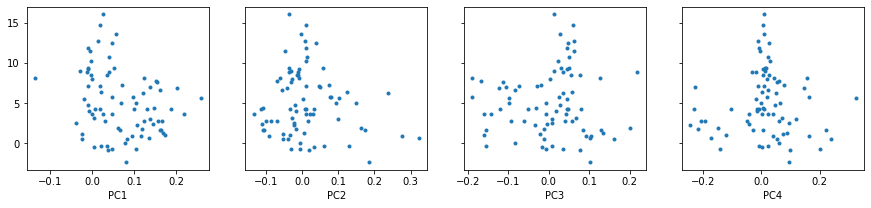

In [170]:
ncomp = 4
usewb = (-2, 6) # ignore all wingbeat except in this range
usewindow = (-100, 200) # ms, window to actually observe around zero'd time
viridis = cmx.get_cmap('viridis')

# Loop over dates
for d in runDates:
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
    dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
    dt.loc[(dt['tdl']<0) | (dt['tdr']<0), ['tdl','tdr']] = np.nan
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    # Group dataframe, prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    mat = np.full((ngroup,groupsize), np.nan)
    stimvar = np.zeros(ngroup)
    # Loop over each pulse, add to matrix
    for i, (name, g) in enumerate(grouped_df):
        vec = g.loc[g.Time>=0]
        mat[i,0:len(vec)] = vec.mx
        stimvar[i] = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        # stimvar[i] = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # stimvar[i] = g.loc[g.wbstate=='stim', 'stimphase'].iloc[0]
    # Create time vector 
    tvec = np.linspace(0, (mat.shape[1]-1)/fsamp, mat.shape[1])
    # Trim nan points (in the future can interpolate nans?)
    tvec = tvec[~np.isnan(mat).any(axis=0)]
    mat = mat[:, ~np.isnan(mat).any(axis=0)]

    # Take PCA
    pca = PCA(n_components=ncomp)
    pc = pca.fit_transform(mat.T)
    
    # Plot stimvar against each PC
    fig, ax = plt.subplots(1, ncomp, figsize=(15,3), sharey=True)
    for i in range(ncomp):
        ax[i].plot(pca.components_[i,:], stimvar, '.')
        ax[i].set_xlabel('PC'+str(i+1))


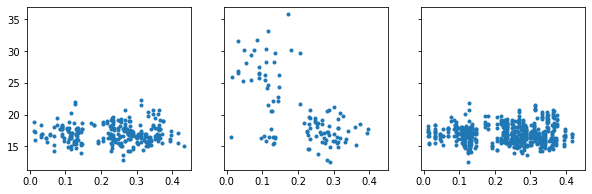

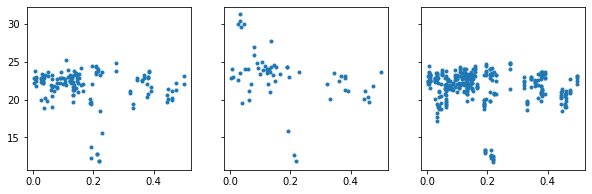

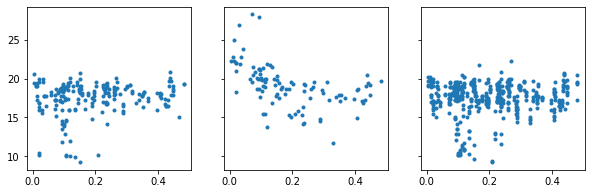

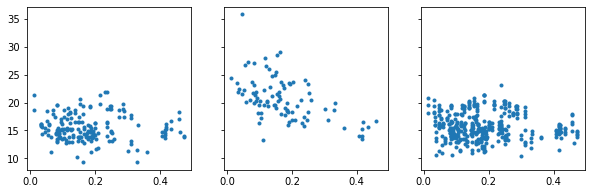

In [163]:
ncomp = 4
usewb = (-2, 6)

aggdict = {}
aggdict['wbstate'] = 'first'
aggdict['stimphase'] = 'first'
aggdict['tdl'] = 'first'
aggdict['tdr'] = 'first'

# Loop over dates
for d in runDates:
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
    dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
    dt.loc[(dt['tdl']<0) | (dt['tdr']<0), ['tdl','tdr']] = np.nan
    
    g = dt.groupby(['date','pulse','wb']).aggregate(aggdict)
    
    fig, ax = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
    for i,state in enumerate(['pre','stim','post']):
        dsub = g.loc[g.wbstate==state]
        ax[i].plot(dsub.stimphase, dsub.tdl, '.')

# Quick look: Does wingbeat frequency/period vary with stimulation-induced change in spike time?

In [ ]:
usewb = (-2, 2) # ignore all wingbeat except in this range
# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
    dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
    dt.loc[(dt['tdl']<0) | (dt['tdr']<0), ['tdl','tdr']] = np.nan
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    deltaT = []
    wbf = []
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        deltaT.append(g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0])
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        wbf.append(1/(len(g.loc[g.wbstate=='stim'])/fsamp))
    sns.jointplot(x=deltaT, y=wbf, kind='hex')

# How wingbeat frequency (length of $F_z$ cycles) is impacted by stimulation

In [ ]:
plt.close('all')
usewb = (-1, 5) # ignore all wingbeat except in this range
fig, ax  = plt.subplots(len(runDates), 1, sharex=True, figsize=(6,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
    dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
    dt.loc[(dt['tdl']<0) | (dt['tdr']<0), ['tdl','tdr']] = np.nan
    # Color setup
    viridis = cmx.get_cmap('viridis')
    maxcol, mincol = 15, -3
    # Zero time
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        # thiscol = g.loc[g.wbstate=='stim', 'tdr'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        dg = g.groupby('wb').size()
        ax[ind].plot(dg.index, (dg.values-dg.values[0])/10, '.-', color=viridis((maxcol-thiscol)/(maxcol-mincol)))
    # Labels
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    tickrange = np.linspace(mincol, maxcol, 10)
    cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                        ticks=(tickrange-mincol)/(maxcol-mincol),
                        cax=cbar_ax)
    cbar.ax.set_yticklabels([str(round(x,3)) for x in tickrange], fontsize=7)
    cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')
    # TODO: Add colorbar to subplot, do right version as well

# How DLM-DVM timing changes after stimulation

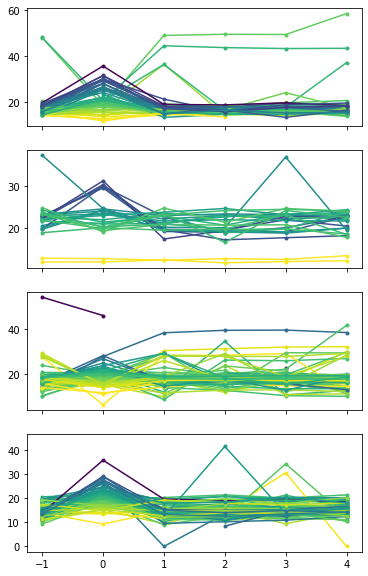

In [33]:
usewb = (-1, 5) # ignore all wingbeat except in this range
fig, ax  = plt.subplots(len(runDates), 1, sharex=True, figsize=(6,10))
viridis = cmx.get_cmap('viridis')
maxcol, mincol = 36, 13
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Recreate first spike columns because I don't trust them
    for m in channelsEMG:
        dt[m+'_fs'] = 0
        dt[m+'_fs'] = dt.groupby(['date','pulse','wb'], group_keys=False).apply(
            lambda g: g[m+'_fs'] + (g[m+'_st'].idxmax() - g[m+'_st'].idxmin()))
    dt['tdl'] = (dt['LDVM_fs']-dt['LDLM_fs'])/10
    dt['tdr'] = (dt['RDVM_fs']-dt['RDLM_fs'])/10
    dt.loc[(dt['tdl']<0), 'tdl'] = np.nan
    dt.loc[(dt['tdr']<0), 'tdr'] = np.nan
    # Zero time
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        dg = g.groupby('wb').aggregate({'wb' : 'first',
                                        'tdl' : 'first'})
        ax[ind].plot(dg.wb, dg.tdl, '.-', color=viridis((maxcol-thiscol)/(maxcol-mincol)))

WHY. Why are $t_{DVM}-t_{DLM}$ values above a certain threshold on wb 0 disappearing on wb 1? There are clearly spikes on wingbeat 1, but they don't show up in _fs and thus don't get counted. It doesn't seem to be the difthresh somehow. When I try to do the first spike counting myself, 20210817_1 just has nothing. WHY

# General notes

- Could use a more general-purpose function to split cycles by any variable or criterion, and return a new dataframe column of wingbeats from that cycle-splitting metric. What if I want to use the hilbert transform of a 20Hz bandpass filtered $M_x$ (or any force or torque)? What about aligning by first or second spike of a given muscle?
- Need way to take stimulation delays that are very long and loop them back around, offset. 

# Ideas

- Align by _mean_ spike time for pre-stim spikes